In [98]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import shap
import sklearn
import numpy as np
import sys
import os

In [10]:
Tree = DecisionTreeRegressor()

In [21]:
target = [-10] * 10 + [10] * 5 + [5] * 20 + [14] * 5
cat_1 = [1] * 10 + [0] * 30
x = [60] * 5 + [45] * 30 +  [50] * 5
cat_2 = [1] * 15 + [0] * 25
data = pd.DataFrame({"cat_1": cat_1,
                     "cat_2": cat_2,
                     "x": x,
                     "target": target})

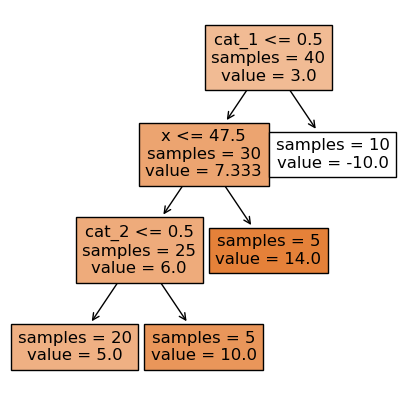

In [70]:
Tree.fit(data.values[:,:-1], data.values[:,-1])
fig, ax = plt.subplots(figsize = (5,5))
plot_tree(Tree, ax = ax, filled=True, feature_names = ["cat_1", "cat_2", "x"], impurity = False)
plt.show()

In [44]:
explainer_tree = shap.TreeExplainer(Tree)
input_shap = np.array([0,1,60])
print(f"Shap values from the fitted explainer: {explainer_tree.shap_values(input_shap)}")
print(f"Theoretical Shap values: {np.array([191/36, 25/18, 155/36])}")

Shap values from the fitted explainer: [5.30555556 1.38888889 4.30555556]
Theoretical Shap values: [5.30555556 1.38888889 4.30555556]


In [58]:
Tree.tree_.value

array([[[  3.        ]],

       [[  7.33333333]],

       [[  6.        ]],

       [[  5.        ]],

       [[ 10.        ]],

       [[ 14.        ]],

       [[-10.        ]]])

In [59]:
Tree.criterion

'squared_error'

In [61]:
tree = Tree.tree_

In [65]:
isinstance(tree, sklearn.tree._tree.Tree)

True

In [66]:
tree.children_left

array([ 1,  2,  3, -1, -1, -1, -1], dtype=int64)

In [67]:
tree.children_right

array([ 6,  5,  4, -1, -1, -1, -1], dtype=int64)

In [68]:
tree.feature

array([ 0,  2,  1, -2, -2, -2, -2], dtype=int64)

In [69]:
tree.threshold

array([ 0.5, 47.5,  0.5, -2. , -2. , -2. , -2. ])

In [74]:
target2 = [-10] * 6 + [10] * 8 + [6] * 4 + [5] * 14 + [4] * 2 + [3] * 3 + [-5] * 3
cat_12 = [1] * 10 + [0] * 30
x2 = [60] * 5 + [45] * 30 +  [50] * 5
cat_22 = [1] * 15 + [0] * 25
data2 = pd.DataFrame({"cat_1": cat_12,
                     "cat_2": cat_22,
                     "x": x2,
                     "target": target2})

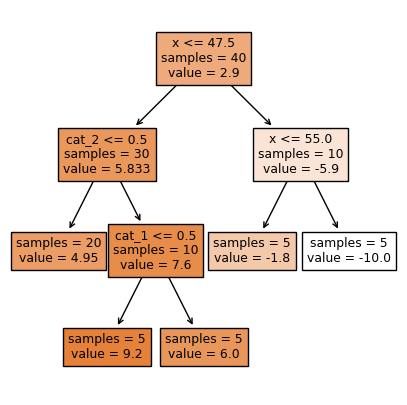

In [75]:
Tree2 = DecisionTreeRegressor()
Tree2.fit(data2.values[:,:-1], data2.values[:,-1])
fig, ax = plt.subplots(figsize = (5,5))
plot_tree(Tree2, ax = ax, filled=True, feature_names = ["cat_1", "cat_2", "x"], impurity = False)
plt.show()

In [78]:
tree2 = Tree2.tree_
tree2.threshold

array([47.5,  0.5, -2. ,  0.5, -2. , -2. , 55. , -2. , -2. ])

In [79]:
tree2.children_right

array([ 6,  3, -1,  5, -1, -1,  8, -1, -1], dtype=int64)

In [80]:
tree2.children_left

array([ 1,  2, -1,  4, -1, -1,  7, -1, -1], dtype=int64)

In [82]:
tree2.weighted_n_node_samples

array([40., 30., 20., 10.,  5.,  5., 10.,  5.,  5.])

In [83]:
tree2.value

array([[[  2.9       ]],

       [[  5.83333333]],

       [[  4.95      ]],

       [[  7.6       ]],

       [[  9.2       ]],

       [[  6.        ]],

       [[ -5.9       ]],

       [[ -1.8       ]],

       [[-10.        ]]])

In [88]:
a = tree2.feature
a

array([ 2,  1, -2,  0, -2, -2,  2, -2, -2], dtype=int64)

In [96]:
np.where(a == 13)[0]

array([], dtype=int64)

In [118]:
sys.path.append(os.path.abspath("../src/helper-functions"))
import tree_shap


In [119]:
nu = tree.value.flatten()
a = tree.children_left
b = tree.children_right
t = tree.threshold
r = tree.weighted_n_node_samples
d = tree.feature
shap_local = tree_shap.cat_tree_shap(input_shap, nu, a, b, t, r, d)


In [120]:
shap_local

array([0., 0., 0.])